In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 인코딩 문제 해결
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [2]:
RUL_01 = pd.read_csv('../behrad3d/nasa-cmaps/versions/1/CMaps/RUL_FD001.txt', header=None, sep=' ')
train_01 = pd.read_csv('../behrad3d/nasa-cmaps/versions/1/CMaps/train_FD001.txt', header=None, sep=' ').dropna(axis=1)
test_01 = pd.read_csv('../behrad3d/nasa-cmaps/versions/1/CMaps/test_FD001.txt', header=None, sep=' ').dropna(axis=1)

col_names = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

train_01.columns = col_names
test_01.columns = col_names

In [39]:
RUL_01 = RUL_01.drop(columns=[1])
RUL_01

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [5]:
# RUL 컬럼 추가
def get_rul(df):
    for unit in df['unit'].unique():
        unit_rul = df[df['unit'] == unit]['cycle'].max()
        df.loc[df['unit'] == unit, 'RUL'] = unit_rul - df[df['unit'] == unit]['cycle']
    return df
train_01 = get_rul(train_01)

In [6]:
train_01.head()

,unit,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187.0


---

진행방향 :

1. 전처리 X baseline 모델 적용 (LightGBM, Support Vector Machine, KNN, Random Forest)
2. 전처리 O 모델 적용 (LightGBM, Support Vector Machine, KNN, Random Forest)
3. 앙상블 모델 적용 (Voting, Stacking)

---

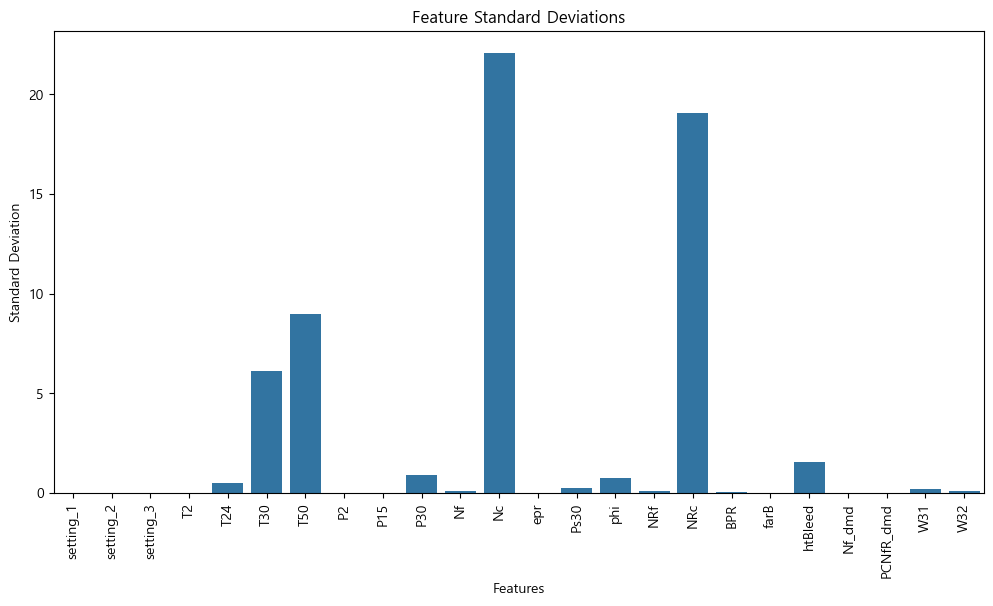

In [8]:
# 모든 피쳐들의 표준편차 확인
feature_std = train_01.iloc[:, 2:-1].std()
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_std.index, y=feature_std.values)
plt.xticks(rotation=90)
plt.title('Feature Standard Deviations')
plt.xlabel('Features')
plt.ylabel('Standard Deviation')
plt.show()

In [9]:
features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

In [ ]:
# 하지만 테스트셋의 정답인 RUL 데이터 셋은 각 유닛별 잔존 수명만 나타냄. -> 테스트셋의 사이클이 끝까지 돌은 시점에서의 정답 값.
# 테스트셋의 마지막 사이클 데이터 추출
unit_last_cycle = test_01.groupby('unit').last()
unit_last_cycle

,cycle,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,P15,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
unit,,,,,,,,,,,,,,,,,,,,,
1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,21.61,...,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,21.61,...,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,21.61,...,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608


In [42]:
# 테스트셋, 각 모델들은 시계열성을 배제하였기 때문에 마지막 사이클 시점만 추출하여 예측에 사용
X_test = unit_last_cycle

y_test = RUL_01.values

---

모델 적용

In [26]:
# 모델 임포트
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# lightgbm
import lightgbm as lgb
# SVM
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor
# Radom Forest
from sklearn.ensemble import RandomForestRegressor

- LightGBM

In [50]:
X = train_01.drop(columns=['unit', 'RUL'])
y = train_01['RUL']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# LightGBM 모델
lgb_model = lgb.LGBMRegressor(n_estimatores = 500,
                              learning_rate=1e-3,
                              max_depth=6,
                              random_state=42,
                              colsample_bytree=0.8, # 특성 샘플링 비율
                              subsample=0.8,         # 데이터 샘플링 비율
                              n_jobs=-1,             # 병렬 처리 사용
                              importance_type='gain'  # 특성 중요도 계산 방식
                              )
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: n_estimatores
[LightGBM] [Warning] Unknown parameter: n_estimatores
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 18
[LightGBM] [Info] Start training from score 107.559683


LGBMRegressor(colsample_bytree=0.8, importance_type='gain', learning_rate=0.001,
              max_depth=6, n_estimatores=500, n_jobs=-1, random_state=42,
              subsample=0.8)

In [51]:
# 훈련셋 평가
y_train_pred_lgb = lgb_model.predict(X_train)
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
print(f'LightGBM Train RMSE: {train_rmse_lgb:.4f}')
# 검증셋 평가
y_val_pred_lgb = lgb_model.predict(X_val)
val_rmse_lgb = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
print(f'LightGBM Validation RMSE: {val_rmse_lgb:.4f}')

[LightGBM] [Warning] Unknown parameter: n_estimatores
LightGBM Train RMSE: 64.7236
[LightGBM] [Warning] Unknown parameter: n_estimatores
LightGBM Validation RMSE: 63.2213


In [52]:
# 테스트셋 예측
y_test_pred_lgb = lgb_model.predict(X_test)
test_rmse_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
print(f'LightGBM Test RMSE: {test_rmse_lgb:.4f}')

[LightGBM] [Warning] Unknown parameter: n_estimatores
LightGBM Test RMSE: 48.3426


---

- SVR

In [53]:
# SVR 모델
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

SVR()

In [54]:
# 훈련셋 평가
y_train_pred_svr = svr_model.predict(X_train)
train_rmse_svr = np.sqrt(mean_squared_error(y_train, y_train_pred_svr))
print(f'SVR Train RMSE: {train_rmse_svr:.4f}')
# 검증셋 평가
y_val_pred_svr = svr_model.predict(X_val)
val_rmse_svr = np.sqrt(mean_squared_error(y_val, y_val_pred_svr))
print(f'SVR Validation RMSE: {val_rmse_svr:.4f}')

SVR Train RMSE: 68.8302
SVR Validation RMSE: 67.3446


In [55]:
# 테스트셋 예측
y_test_pred_svr = svr_model.predict(X_test)
test_rmse_svr = np.sqrt(mean_squared_error(y_test, y_test_pred_svr))
print(f'SVR Test RMSE: {test_rmse_svr:.4f}')

SVR Test RMSE: 48.7142


---

- KNN

In [56]:
# KNN 모델
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [57]:
# 훈련셋 평가
y_train_pred_knn = knn_model.predict(X_train)
train_rmse_knn = np.sqrt(mean_squared_error(y_train, y_train_pred_knn))
print(f'KNN Train RMSE: {train_rmse_knn:.4f}')
# 검증셋 평가
y_val_pred_knn = knn_model.predict(X_val)
val_rmse_knn = np.sqrt(mean_squared_error(y_val, y_val_pred_knn))
print(f'KNN Validation RMSE: {val_rmse_knn:.4f}')

KNN Train RMSE: 32.9512
KNN Validation RMSE: 39.7138


In [58]:
# 테스트셋 예측
y_test_pred_knn = knn_model.predict(X_test)
test_rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
print(f'KNN Test RMSE: {test_rmse_knn:.4f}')

KNN Test RMSE: 36.3344


---

In [59]:
# RF 모델
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
# 훈련셋 평가
y_train_pred_rf = rf_model.predict(X_train)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
print(f'RF Train RMSE: {train_rmse_rf:.4f}')
# 검증셋 평가
y_val_pred_rf = rf_model.predict(X_val)
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
print(f'RF Validation RMSE: {val_rmse_rf:.4f}')

RF Train RMSE: 5.9918
RF Validation RMSE: 16.1081


In [60]:
# 테스트셋 예측
y_test_pred_rf = rf_model.predict(X_test)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(f'RF Test RMSE: {test_rmse_rf:.4f}')

RF Test RMSE: 25.8794
